# Logistic Regression

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

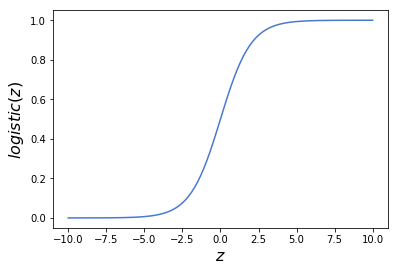

In [2]:
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic);
plt.xlabel('$z$', fontsize=16);
plt.ylabel('$logistic(z)$', fontsize=16);

In [3]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


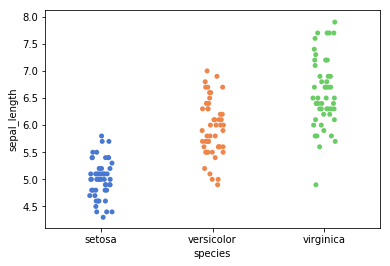

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True);

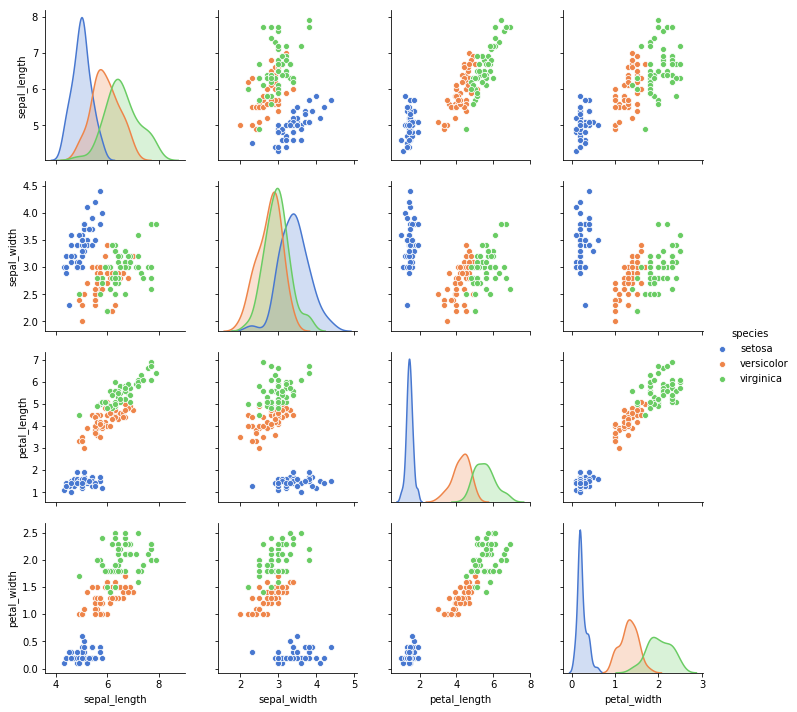

In [5]:
sns.pairplot(iris, hue='species', diag_kind='kde');

In [6]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [7]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    #theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))
    # the theta of the Bernoulli is derived from the logistic inverse link function
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

#     start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, chains=1, njobs=1)

Sequential sampling (1 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 5500/5500 [00:14<00:00, 367.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


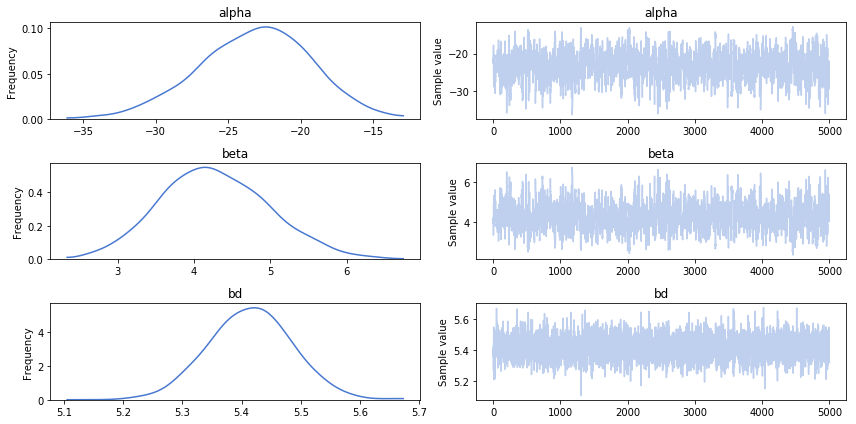

In [8]:
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(trace_0, varnames);

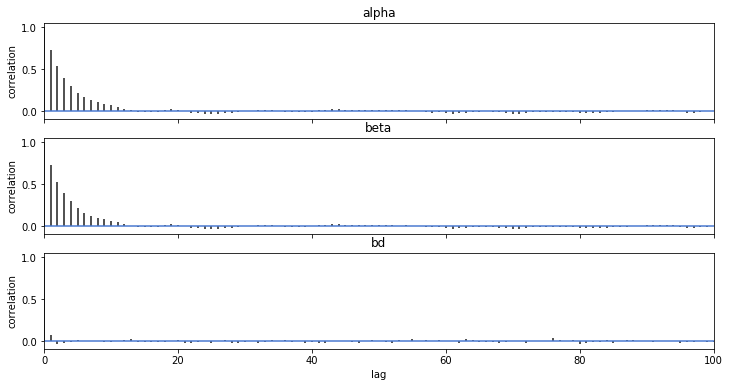

In [9]:
pm.autocorrplot(trace_0, varnames);

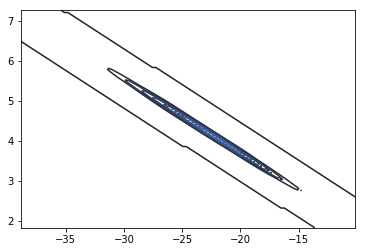

In [10]:
sns.kdeplot(trace_0['alpha'], trace_0['beta']);

In [11]:
pm.summary(trace_0, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-23.17,3.84,1.31e-01,-30.82,-15.89
beta,4.28,0.71,2.42e-02,2.94,5.70
bd,5.42,0.07,9.42e-04,5.28,5.55


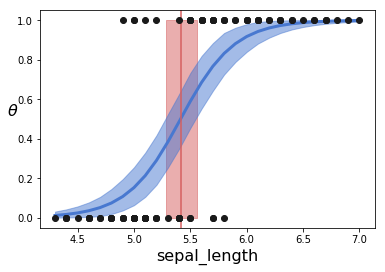

In [12]:
theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_0['bd'].mean(), ymax=1, color='r');
bd_hpd = pm.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5);

plt.plot(x_0, y_0, 'o', color='k');
theta_hpd = pm.hpd(trace_0['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5);

plt.xlabel(x_n, fontsize=16);
plt.ylabel(r'$\theta$', rotation=0, fontsize=16);

In [13]:
def classify(n, threshold):
    """
    A simple classifying function
    """
    n = np.array(n)
    mu = trace_0['alpha'].mean() + trace_0['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob >= threshold

classify([5, 5.5, 6], 0.5)

(array([0.15, 0.59, 0.92]), array([False,  True,  True]))

## Multiple logistic regression

In [14]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] #['petal_length', 'petal_width'] 
x_1 = df[x_n].values

#x_1 = (x_1 - x_1.mean(axis=0))/x_1.std(axis=0) #
#x_1 = (x_1 - x_1.mean(axis=0))

In [15]:
with pm.Model() as model_1:
    # We define the prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_1, beta)
    # Apply the logistic linking function
    theta = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    # Sampling
    trace_1 = pm.sample(5000,chains=1, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 5500/5500 [00:20<00:00, 272.09it/s]
The acceptance probability does not match the target. It is 0.8931604002334997, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


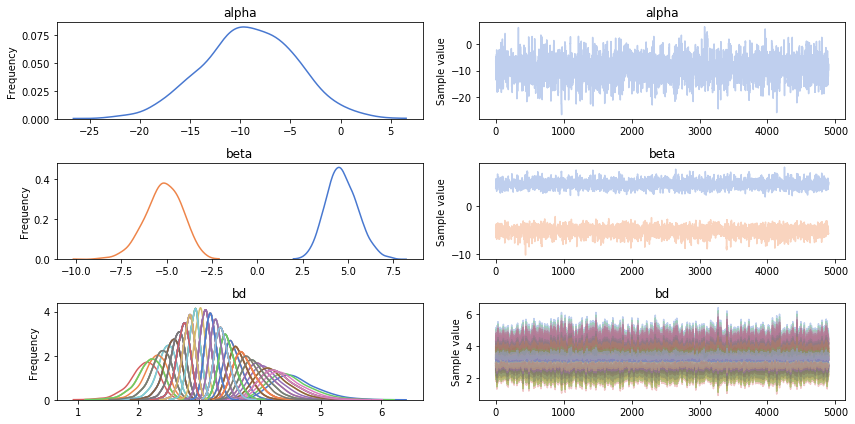

In [16]:
chain_1 = trace_1[100:]
pm.traceplot(chain_1);

#### Note that now the boundary decision has 100 parameters, one for each data point

In [17]:
pm.summary(chain_1, ['alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-9.12,4.67,0.11,-18.29,-0.17
beta__0,4.67,0.86,0.02,3.06,6.39
beta__1,-5.18,1.03,0.02,-7.18,-3.20


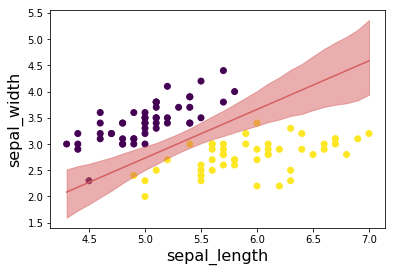

In [18]:
idx = np.argsort(x_1[:,0])
ld = chain_1['bd'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=y_0);
plt.plot(x_1[:,0][idx], ld, color='r');

ld_hpd = pm.hpd(chain_1['bd'])[idx]
plt.fill_between(x_1[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16);
plt.ylabel(x_n[1], fontsize=16);

## Correlated variables

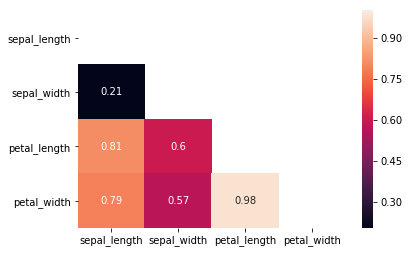

In [19]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True);

## Unbalanced Classes

In [20]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:] #df[22:78]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

In [21]:
with pm.Model() as model_3:
    # We define the a prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_3, beta)
    # Aplly the logistic linking function
    p = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    ld = pm.Deterministic('ld', -alpha/beta[1] - beta[0]/beta[1] * x_3[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_3)
    trace_3 = pm.sample(5000,chains=1, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 5500/5500 [00:14<00:00, 383.43it/s]
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


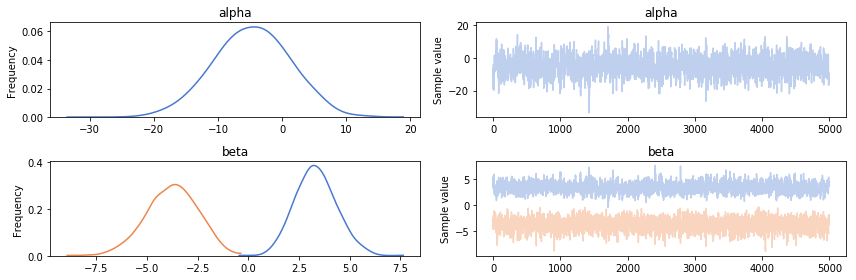

In [22]:
cadena_3 = trace_3[:]
varnames = ['alpha', 'beta']
pm.traceplot(cadena_3, varnames);

In [23]:
pm.summary(cadena_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-4.70,5.94,0.18,-15.93,6.74
beta__0,3.33,1.01,0.03,1.30,5.25
beta__1,-3.77,1.27,0.03,-6.22,-1.36


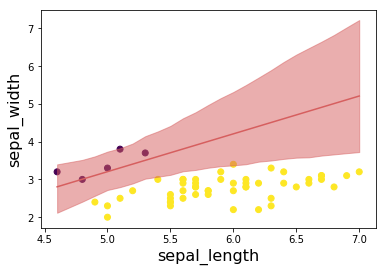

In [24]:
idx = np.argsort(x_3[:,0])
ld = trace_3['ld'].mean(0)[idx]
plt.scatter(x_3[:,0], x_3[:,1], c=y_3);
plt.plot(x_3[:,0][idx], ld, color='r');

ld_hpd = pm.hpd(trace_3['ld'])[idx]
plt.fill_between(x_3[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16);
plt.ylabel(x_n[1], fontsize=16);

## Softmax logistic regression (AKA multinomial regression)

In [25]:
iris = sns.load_dataset("iris")
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)
#x_s = (x_s - x_s.mean(axis=0))

In [26]:
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,3))

    mu = alpha + pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    step = pm.NUTS()
    trace_s = pm.sample(2000, step, chains=1, njobs=1)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

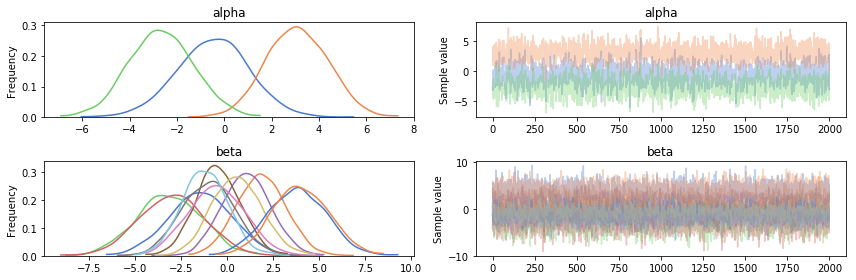

In [27]:
pm.traceplot(trace_s);

In [28]:
pm.summary(trace_s)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,-0.50,1.50,0.04,-3.64,2.20
alpha__1,3.07,1.29,0.03,0.56,5.51
alpha__2,-2.68,1.35,0.03,-5.19,0.08
beta__0_0,-1.45,1.68,0.04,-4.87,1.64
beta__0_1,1.04,1.29,0.04,-1.41,3.52
beta__0_2,0.53,1.34,0.04,-2.24,3.02
beta__1_0,1.85,1.31,0.03,-0.64,4.39
beta__1_1,-0.50,1.21,0.03,-2.77,1.95
beta__1_2,-1.20,1.25,0.03,-3.55,1.31
beta__2_0,-3.17,1.73,0.04,-6.72,-0.08


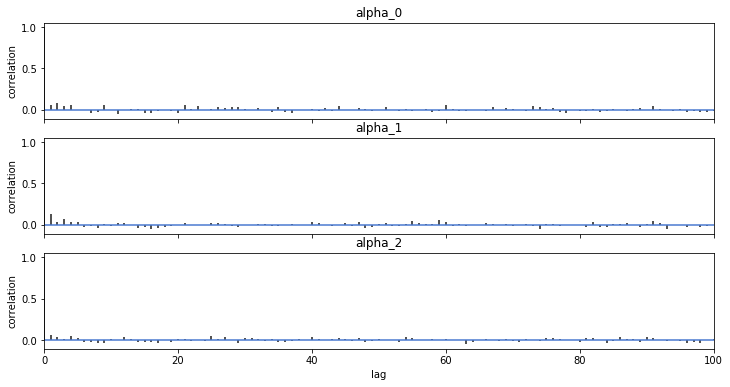

In [29]:
pm.autocorrplot(trace_s, varnames=['alpha']);

In [30]:
probs = trace_s['alpha'].mean(axis=0) + np.dot(x_s, trace_s['beta'].mean(axis=0))
y_pred = []
for point in probs:
    # each array appended contains the softmax estimates of each class
    y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
print('Accuracy on training data is {0:.2%}'.format(np.sum(y_s == np.argmax(y_pred, axis=1))/len(y_s)))

Accuracy on training data is 97.33%


In [31]:
with pm.Model() as model_sf:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=2)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,2))
    
    alpha_f = tt.concatenate([[0] , alpha])
    beta_f = tt.concatenate([np.zeros((4,1)) , beta], axis=1)

    mu = alpha_f + pm.math.dot(x_s, beta_f)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    step = pm.NUTS()
    trace_sf = pm.sample(2000, step, chains=1, njobs=1)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (1 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 2500/2500 [00:11<00:00, 222.00it/s]
The acceptance probability does not match the target. It is 0

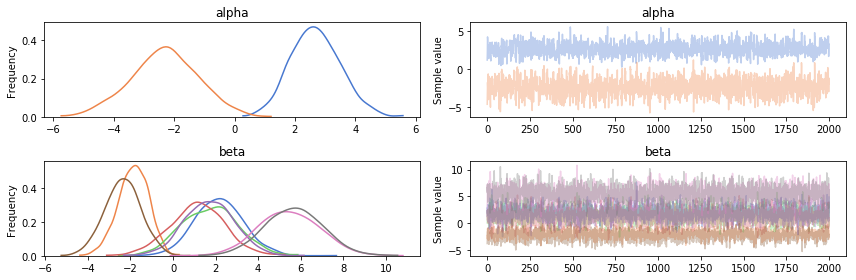

In [32]:
pm.traceplot(trace_sf);

#### we get much better defined $\alpha$'s and $\beta$'s than before because we didn't parametrize the problem correctly. We need to fix the number of parameters to $num_{classes} - 1$, since all probabilities must sum to one we had too many parameters in the first instance of the model. We do this by setting the first $\alpha$ and first $\beta$'s to zero (see code).

In [33]:
pm.summary(trace_sf)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.68,0.82,0.02,1.12e+00,4.35
alpha__1,-2.34,1.12,0.03,-4.49e+00,-0.09
beta__0_0,2.14,1.12,0.03,2.37e-03,4.47
beta__0_1,1.69,1.16,0.03,-5.15e-01,4.04
beta__1_0,-1.88,0.70,0.02,-3.23e+00,-0.52
beta__1_1,-2.37,0.84,0.02,-3.99e+00,-0.71
beta__2_0,1.73,1.30,0.03,-6.13e-01,4.34
beta__2_1,5.43,1.42,0.04,2.49e+00,7.98
beta__3_0,1.12,1.27,0.03,-1.38e+00,3.65
beta__3_1,5.66,1.35,0.03,3.11e+00,8.40


## Linear discriminat Analysis

In [34]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [35]:
with pm.Model() as model_lda:

    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigma, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=mus[1], sd=sigma, observed=x_0[50:])
    
    bd = pm.Deterministic('bd', (mus[0]+mus[1])/2)
    
    trace_lda = pm.sample(5000, chains=1, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mus]
100%|██████████| 5500/5500 [00:03<00:00, 1703.58it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


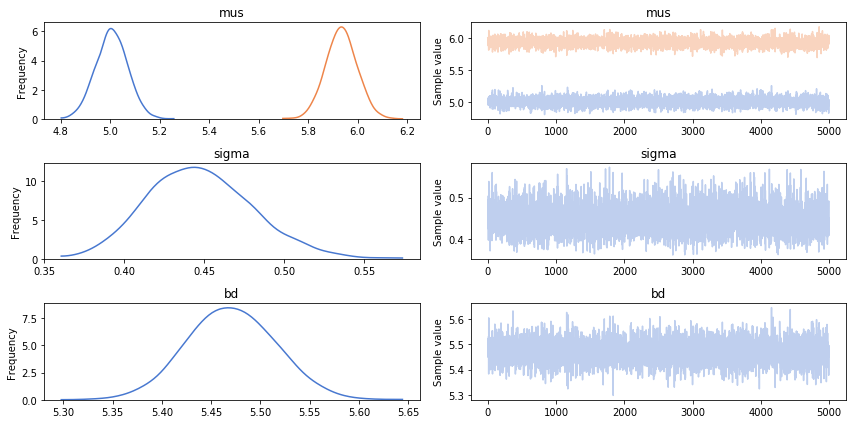

In [36]:
pm.traceplot(trace_lda);

In [37]:
pm.summary(trace_lda)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mus__0,5.01,0.06,9.93e-04,4.88,5.13
mus__1,5.93,0.06,9.24e-04,5.81,6.06
sigma,0.45,0.03,4.35e-04,0.38,0.51
bd,5.47,0.04,6.29e-04,5.39,5.56


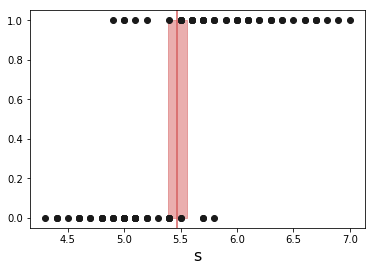

In [38]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='r');
bd_hpd = pm.hpd(trace_lda['bd']);
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5);
plt.plot(x_0, y_0, 'o', color='k');
plt.xlabel(x_n[0], fontsize=16);

In [39]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian buster/sid and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2
Seaborn 0.9.0
Pandas 0.23.4


/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
